In [1]:
# SageMath version: 10.0

# See the constants defined in: https://github.com/zkcrypto/jubjub?tab=readme-ov-file

# the base field of JubJub
p = 0x73eda753299d7d483339d80809a1d80553bda402fffe5bfeffffffff00000001
Fp = GF(p) 

# Edwards curve: e(x, y) = a * x^2 + y^2 - 1 - d * x^2 * y^2
ED_a = Fp(-1)
ED_d = Fp(-1) * Fp(10240) / Fp(10241)

In [2]:
# Montgomery curve: m(x, y) = x^3 + J * x^2 - K * y^2 + x
# Transform relation between Montgomery and Edwards, see: https://www.rfc-editor.org/rfc/rfc9380.html#appx-rational-map
MONT_J = Fp(2) * (ED_a + ED_d) / (ED_a - ED_d)
MONT_K = Fp(4) /(ED_a - ED_d)

(MONT_J, MONT_K)


(40962,
 52435875175126190479447740508185965837690552500527637822603658699938581143549)

In [3]:
# Weierstrass curve: w(x, y) = x^3 - y^2 + A * x + B
# Transform relation between Montgomery and Weierstrass, see: https://www.rfc-editor.org/rfc/rfc9380.html#appx-rational-map
WEI_A = (Fp(3) - MONT_J ** 2) / (Fp(3) * MONT_K ** 2)
WEI_B = (Fp(2) * MONT_J ** 3 - Fp(9) * MONT_J) / (Fp(27) * MONT_K ** 3)
(WEI_A, WEI_B)

(52296097456646850916096512823759002727550416093741407922227928430486925478210,
 48351165704696163914533707656614864561753505123260775585269522553028192119009)

In [4]:
def find_z_svdw(F, A, B, init_ctr=1):
    g = lambda x: F(x)^3 + F(A) * F(x) + F(B)
    h = lambda Z: -(F(3) * Z^2 + F(4) * A) / (F(4) * g(Z))
    # NOTE: if init_ctr=1 fails to find Z, try setting it to F.gen()
    ctr = init_ctr
    while True:
        for Z_cand in (F(ctr), F(-ctr)):
            # Criterion 1:
            #   g(Z) != 0 in F.
            if g(Z_cand) == F(0):
                continue
            # Criterion 2:
            #   -(3 * Z^2 + 4 * A) / (4 * g(Z)) != 0 in F.
            if h(Z_cand) == F(0):
                continue
            # Criterion 3:
            #   -(3 * Z^2 + 4 * A) / (4 * g(Z)) is square in F.
            if not is_square(h(Z_cand)):
                continue
            # Criterion 4:
            #   At least one of g(Z) and g(-Z / 2) is square in F.
            if is_square(g(Z_cand)) or is_square(g(-Z_cand / F(2))):
                return Z_cand
        ctr += 1

jubjub_z = find_z_svdw(Fp, WEI_A, WEI_B)
jubjub_z

52435875175126190479447740508185965837690552500527637822603658699938581184511

In [5]:
P.<x, y> = PolynomialRing(Fp, 2)
K = FractionField(P)
x, y = K.gens()

In [6]:
edwards_form = ED_a * x ** 2 + y ** 2 - 1 - ED_d * x ** 2 * y ** 2
edwards_form

33178837138445241119697427838399087845741117098273517536419461807987697107280*x^2*y^2 - x^2 + y^2 + 52435875175126190479447740508185965837690552500527637822603658699938581184512

In [7]:
montgomery_form = x * x * x + MONT_J * x ** 2 - MONT_K * y * y  + x
montgomery_form

x^3 + 40962*x^2 + 40964*y^2 + x

In [8]:
weierstrass_form = x ** 3 - y * y + WEI_A * x + WEI_B
weierstrass_form

x^3 - y^2 + 52296097456646850916096512823759002727550416093741407922227928430486925478210*x + 48351165704696163914533707656614864561753505123260775585269522553028192119009

In [9]:
def g_function (x):
    return x ** 3 + WEI_A * x + WEI_B


In [10]:
c1 = g_function(jubjub_z)
c1

48630721141654843041236163025468790782033777936833235386020983091931503531607

In [11]:
c2 = - jubjub_z / 2
c2

1

In [12]:
tmp_c3 = - c1 * (3 * jubjub_z ** 2 + 4 * WEI_A)
kronecker(tmp_c3, p)

1

In [13]:
# tmp_c3 is quadratic-residu based on the above result
c3 = tmp_c3.sqrt()
c3

24146520738251038143323677064763613433350189995985671344066102628610221898822

In [14]:
c4 = -4 * c1 / (3 * jubjub_z ** 2 + 4 * WEI_A)
c4

31679371333262911747971259189439939822940330684566412014642200553153953520023

In [15]:
type(c4)

<class 'sage.rings.finite_rings.integer_mod.IntegerMod_gmp'>

In [16]:
mod(c4, 2)

1

In [17]:
def is_square(x):
    if kronecker(x, p) == 1:
        return True
    else:
        return False

In [18]:
def field_to_weierstrass(u):
    # 1.  tv1 = u^2
    tv1 = u ** 2
    # 2.  tv1 = tv1 * c1
    tv1 = tv1 * c1
    # 3.  tv2 = 1 + tv1
    tv2 = 1 + tv1
    # 4.  tv1 = 1 - tv1
    tv1 = 1 - tv1
    # 5.  tv3 = tv1 * tv2
    tv3 = tv1 * tv2
    # 6.  tv3 = inv0(tv3)
    if tv3 != 0:
        tv3 = 1 / tv3
    # 7.  tv4 = u * tv1
    tv4 = u * tv1
    # 8.  tv4 = tv4 * tv3
    tv4 = tv4 * tv3
    # 9.  tv4 = tv4 * c3
    tv4 = tv4 * c3
    # 10.  x1 = c2 - tv4
    x1 = c2 - tv4
    # 11. gx1 = x1^2
    gx1 = x1 ** 2
    # 12. gx1 = gx1 + A
    gx1 = gx1 + WEI_A
    # 13. gx1 = gx1 * x1
    gx1 = gx1 * x1
    # 14. gx1 = gx1 + B
    gx1 = gx1 + WEI_B
    # 15. e1 = is_square(gx1)
    e1 = is_square(gx1)
    # 16. x2 = c2 + tv4
    x2 = c2 + tv4
    # 17. gx2 = x2^2
    gx2 = x2 ** 2
    # 18. gx2 = gx2 + A
    gx2 = gx2 + WEI_A
    # 19. gx2 = gx2 * x2
    gx2 = gx2 * x2
    # 20. gx2 = gx2 + B
    gx2 = gx2 + WEI_B
    # 21. e2 = is_square(gx2) AND NOT e1
    e2 = is_square(gx2) and (not e1)
    # 22. x3 = tv2^2
    x3 = tv2 ** 2
    # 23. x3 = x3 * tv3
    x3 = x3 * tv3
    # 24. x3 = x3^2
    x3 = x3 ** 2
    # 25. x3 = x3 * c4
    x3 = x3 * c4
    # 26. x3 = x3 + Z
    x3 = x3 + jubjub_z
    # 27. x = CMOV(x3, x1, e1)   # x = x1 if gx1 is square, else x = x3
    if e1 == True:
        x = x1
    else:
        x = x3 # x = x1 if gx1 is square, else x = x3
    # 28. x = CMOV(x, x2, e2)    # x = x2 if gx2 is square and gx1 is not
    if e2 == True:
        x = x2
    # 29. gx = x^2
    gx = x ** 2
    # 30. gx = gx + A
    gx = gx + WEI_A
    # 31. gx = gx * x
    gx = gx * x
    # 32. gx = gx + B
    gx = gx + WEI_B
    # 33. y = sqrt(gx)
    y = gx.sqrt()
    # 34. e3 = sgn0(u) == sgn0(y)
    e3 = (mod(u, 2) == mod(y, 2))
    # 35. y = CMOV(-y, y, e3)
    if e3 == False:
        y = -y  
    # 36. return (x, y)
    return (x, y)


In [19]:
# Given (x, y) in Weierstrass curve, convert to the point in Montgomery curve
# Algorithm from: https://www.rfc-editor.org/rfc/rfc9380.html#appendix-D.2-5
def weierstrass_to_montgomery(x, y):
    return ((Fp(3) * MONT_K * x - MONT_J) / Fp(3), y * MONT_K)


In [20]:
# Algorithm from: https://www.rfc-editor.org/rfc/rfc9380.html#appendix-D.1-12
def montgomery_to_edwards(s, t):
    tv1 = s + 1
    tv2 = tv1 * t        # (s + 1) * t
    # tv2 = inv0(tv2)      # 1 / ((s + 1) * t)
    if tv2 != 0:
        tv2 = 1 / tv2
    v = tv2 * tv1      # 1 / t
    v = v * s          # s / t
    w = tv2 * t        # 1 / (s + 1)
    tv1 = s - 1
    w = w * tv1        # (s - 1) / (s + 1)
    # e = tv2 == 0
    # w = CMOV(w, 1, e)  # handle exceptional case
    if tv2 == 0:
        w = 1
    return (v, w)

In [21]:
E = EllipticCurve(Fp, [WEI_A, WEI_B])
P = E.random_point()
(a, b) = P.xy()

In [22]:
# the resulting point falls into the related Weierstsrass curve
weierstrass_form(a, b) == 0

True

In [23]:
r = Fp.random_element()
(a, b) = field_to_weierstrass(r)
# the resulting point falls into the related Weierstsrass curve
weierstrass_form(a, b) == 0

True

In [24]:
# the resulting point falls into the related Montgomery curve
(c, d) = weierstrass_to_montgomery(a, b)
montgomery_form(c, d) == 0

True

In [25]:
# the resulting point falls into the related twisted Edwards curve
(e, f) = montgomery_to_edwards(c, d) 
edwards_form(e, f) == 0

True

In [26]:
# test n random points for the correctness
def test(n):
    for i in range(n):
        E = EllipticCurve(Fp, [WEI_A, WEI_B])
        P = E.random_point()
        Q = 8 * P
        (a, b) = Q.xy()
        not_on_weierstrass = weierstrass_form(a, b) != 0

        (c, d) = weierstrass_to_montgomery(a, b)
        not_on_montgomery = montgomery_form(c, d) != 0

        (e, f) = montgomery_to_edwards(c, d) 
        not_on_edwards = edwards_form(e, f) != 0
    
        if not_on_montgomery | not_on_weierstrass | not_on_edwards:
            print("point not on the curve!")
            return
    
    print("pass")

test(10)





pass


In [27]:
kronecker(7, p) # i.e 7 is a quadratic non-residue

-1

In [28]:
kronecker(ED_d, p) # i.e ED_d is a quadratic non-residue

-1

In [29]:
# Given an integer with 256 bits in hex, convert it into 4 limbs of 64 bits where the least significent limb is put first.

def u_64_little_endian(n):
    str_hex = n
    str_hex_without_0x = str_hex[2:]
    # pad 0s into hex litteral of 64 digits for the 256 bits 
    full_width_str = '0' * (64 - len(str_hex_without_0x)) + str_hex_without_0x
    assert len(full_width_str) == 64

    res = []
    # divide the litteral into 4 limbs of 64 bits, the least significent limb is put first
    for i in range(4):
        temp = '0x' + full_width_str[64 - 16 * (i + 1) : 64 - 16 * i]
        res.append(temp)
    return res

# Output a rust-friendly form of 4 limbs representation for the field element:
# F::from_raw([
# 0x1234567890123456,
# 0x1234567890123456,
# 0x1234567890123456,
# 0x1234567890123456,
# ]),

def print_for_rust(elem):
    print('Base::from_raw([')
    for limb in u_64_little_endian(elem):
        print(limb + ",")
    print(']),')

In [30]:
# Return the rust-friendly form of -1 in Fp
print_for_rust(hex(p-1))

Base::from_raw([
0xffffffff00000000,
0x53bda402fffe5bfe,
0x3339d80809a1d805,
0x73eda753299d7d48,
]),


In [31]:
print_for_rust(hex(jubjub_z))

Base::from_raw([
0xfffffffeffffffff,
0x53bda402fffe5bfe,
0x3339d80809a1d805,
0x73eda753299d7d48,
]),


In [32]:
print_for_rust(hex(WEI_A))

Base::from_raw([
0xc50d34dcd4c20942,
0x20535e745e639334,
0x976220a0378a2328,
0x739e8acf6e7266e8,
]),


In [33]:
print_for_rust(hex(WEI_B))

Base::from_raw([
0x7120c33b4c6628e1,
0xbbf51483ff8366ac,
0xf4c60001b55614b0,
0x6ae5ca3c3f667667,
]),


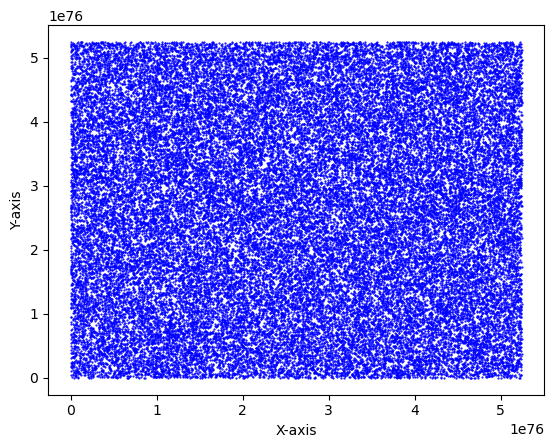

In [34]:
# draw n random points of Jubjub
import matplotlib.pyplot as plt

def draw_hash_to_curve_points(n):
    x = []
    y = []
    for i in range(n):
        E = EllipticCurve(Fp, [WEI_A, WEI_B])
        r = Fp.random_element()
        (xr, yr) = field_to_weierstrass(r)
        P = E(xr, yr)
        Q = 8 * P
        (a, b) = Q.xy()
        (c, d) = weierstrass_to_montgomery(a, b)
        (e, f) = montgomery_to_edwards(c, d) 
        x.append(e)
        y.append(f)
    plt.scatter(x, y, color="blue", s=0.3)

    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    

    # Show the plot
    plt.show()
    
draw_hash_to_curve_points(50000)

In [35]:
hex_p = "0x73eda753299d7d483339d80809a1d80553bda402fffe5bfeffffffff00000001"
int_p = int(hex_p, 16)
print(int_p)


52435875175126190479447740508185965837690552500527637822603658699938581184513
